In [2]:
# imports and data collection functions
import requests
def get_usgs_sf(state, start_date, end_date):
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&stateCd=%s&startDT=%s-01-01&endDT=%s-12-31&siteType=ST&parameterCd=00060&statCd=00003" % (state,start_date, end_date)
    try:
        req = requests.post(waterservices)
        return req.json()
    except:
        print ('Error trying to retrieve data for',state,'; retrying')
        #time.sleep(5)
        try:
            req = requests.post(waterservices)
            return req.json()
        except:
            return {"error": "Error on USGS access"}
        
def get_usgs_sf_code(code, start_date, end_date):
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&sites=%s&&startDT=%s-01-01&endDT=%s-12-31&siteType=ST&parameterCd=00060&statCd=00003" % (code, start_date, end_date)
    try:
        req = requests.post(waterservices)
        return req.json()
    except:
        print ('Error trying to retrieve data; retrying')
        #time.sleep(5)
        try:
            req = requests.post(waterservices)
            return req.json()
        except:
            return {"error": "Error on USGS access"}

# Date collection
def get_gw_date(data, site, index):
    return data["value"]["timeSeries"][site]["values"][0]["value"][index]["dateTime"][0:10]
# Value
def get_gw_value(data, site, index):
    return float(data["value"]["timeSeries"][site]["values"][0]["value"][index]["value"])
def num_of_reps(data, site):
    return len(data["value"]["timeSeries"][site]["values"][0]["value"])
# Site name
def get_site(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteName"]
def get_site_code(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteCode"][0]["value"]
# Coordinates
def get_coordinates(data, site):
    coordinates = [data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["latitude"], data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["longitude"]]
    return coordinates
# Show all data for a site
def show_site_data(data, site, print_data):
    graph = {}
    values_len = len(data["value"]["timeSeries"][site]["values"][0]["value"])
    if values_len == 0:
        return 0
    for i in range(values_len):
        if print_data:
            print(f"   {get_gw_date(data, site, i)}:  {get_gw_value(data, site, i)}")
        if float(get_gw_value(data, site, i)) > -100 and float(get_gw_value(data, site, i)) < 100:
            graph[get_gw_date(data, site, i)] = get_gw_value(data, site, i)
    return graph

In [3]:
# get_station_info(data[], "state", "start_date", "end_date")
import datetime as dt

'''
find sites with most data
    weekly
    daily
look at value length
need 30+ years of data too

datetime import (learn that!)
'''
def sortkey3(e):
    return e[2]

def get_station_info(data, state, start_date, end_date):
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        reps = num_of_reps(data, i)
        if reps > 9999:
            differences = []
            '''
            for num in range(reps):
                if num + 1 < reps:
                    value1 = get_gw_date(data, i, num)
                    value2 = get_gw_date(data, i, num + 1)
                    value3 = dt.datetime(int(value1[0:4]), int(value1[5:7]), int(value1[8:10]))
                    value4 = dt.datetime(int(value2[0:4]), int(value2[5:7]), int(value2[8:10]))
                    differences.append([value1, (value4 - value3).days])
            # calculate average duration between each input
            #print(differences)
            curr_category = ''
            category = ''
            temp_list = []
            category_lst = []
            start_d = ''
            
            for val in differences:
                if val[1] > 0 and val[1] < 4:
                    category = 'daily'
                elif val[1] > 5 and val[1] < 10:
                    category = 'weekly'
                elif val[1] > 25 and val[1] < 35:
                    category = 'monthly'
                else:
                    category = ''
                if curr_category == '':
                    curr_category = category
                    start_d = val[0]
                if category != curr_category:
                    temp_list.append(category)
                    if len(temp_list) == 3:
                        category_lst.append([start_d, val[0], curr_category])
                        curr_category = category
                        start_d = val[0]
                        temp_list = []
            dailys = 0
            weeklys = 0
            monthlys = 0
            for j in category_lst:
                if j[2] == "daily":
                    dailys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
                if j[2] == "weekly":
                    weeklys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
                if j[2] == "monthly":
                    monthlys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
            station = get_site(data, i)
            stations.append([i, station ,f'{reps} total entries', get_gw_date(data, i, 0), f"daily for {dailys} total days ({dailys / 365:.1f} years), weekly across {weeklys/7:.1f} weeks ({weeklys/7/52:.1f} years), monthly across approx. {monthlys/30.43:.1f} months", f"SiteCode = {get_site_code(data, i)}"])'''
            stations.append([i, get_site(data, i) ,f'{reps} total entries', get_gw_date(data, i, 0), f"SiteCode = {get_site_code(data, i)}"])
    stations.sort(reverse = True, key=sortkey3)
    nums = []
    site_codes = []
    for i in stations:
        #print(i)
        print(f'{i[0]}    {i[1]}\n\t   {i[2]}, first entry: ({i[3]}), {i[4]}')
        # print(f'{i[0]}    {i[1]}\n\t   {i[2]}, first entry: ({i[3]})\n\t\t{i[4]}\n')
        nums.append(i[0])
        site_codes.append(i[4])
    print(nums)
    print(len(nums))
    print(site_codes)

In [4]:
# graph_comparison(data[], "date", "start_date", "end_date", index_of_site, window_in_wks, if_plotting, percentile) & daily_analysis()
# daily_analysis(graph[], start(dt), end(dt), "date", "end_date", start2(dt))
# change in gw levels for one station, sorted from decrease to increase
import matplotlib.pyplot as plt
import numpy as np

MONTH_DATA = [31,28,31,30,31,30,31,31,30,31,30,31,31]
# Avg every day
import datetime as dt
MON_ACCUM = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

def daily_analysis(graph, start, end, date, end_date, start2):
    date_data = []
    for date in list(graph.keys()):
        #print(str(graph(date)))
        date_data.append([dt.datetime(int(date[0:4]),int(date[5:7]),int(date[8:10])), graph[date]])
    total_data = []
    while start.year < int(end_date):
        lst = []
        accum = 0
        for i in date_data:
            if i[0] >= start and i[0] <= end:
                lst.append(i)
                accum += i[1]
        if len(lst):
            total_data.append([start2.year, accum / len(lst)])
        #if start.year % 4 == 0 and start.month == 2:
            # LEAP YEAR
        start = dt.datetime(start.year + 1, start.month, start.day)
        start2 = dt.datetime(start2.year + 1, start2.month, start2.day)
        end = dt.datetime(end.year + 1, end.month, end.day)
    return total_data

def sortkey2(e):
    return e[1]

def graph_comparison(graph, date, start_date, end_date, index_of_site, window, plotting, percentile):
    if len(date) == 5:
        date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
        start = date + dt.timedelta(weeks=-1 * window)
        end = date + dt.timedelta(weeks=window,days=-1)
        start2 = date + dt.timedelta(weeks=window)
        end2 = date + dt.timedelta(weeks=3 * window,days=-1)
    else:
        start = dt.datetime(int(start_date), int(date), 1)
        end = dt.datetime(int(start_date), int(date), int(MONTH_DATA[int(date) - 1]))
        start2 = end + dt.timedelta(days=1)
        end2 = end + dt.timedelta(days= MONTH_DATA[int(date)] + 1)
    #if plotting:
        #print(f'Range of data set 1: {start} - {end}\nRange of data set 2: {start2} - {end2}')
    first_set = daily_analysis(graph, start, end, date, end_date, start)
    second_set = daily_analysis(graph, start2, end2, date, end_date, start)
    plottable = []
    for i in first_set:
        for j in second_set:
             if j[0] == i[0]:
                  plottable.append([i[0], j[1] - i[1]])
    dct = {}
    plottable.sort(key=sortkey2)
    for i in plottable:
        if plotting:
            dct[(str(i[0]))[2:4]] = i[1]
        else:
            dct[(str(i[0]))] = i[1]
    if plotting:
        plt.bar(dct.keys(), dct.values(), color = "green", width = 0.8)
        plt.xlabel("Year")
        plt.ylabel("Value")
        plt.title("Streamflow (%s) versus period after" % (date))
        plt.show()
        for i in dct.keys():
            print(f'{i}: {dct[i]:.2f}')
    else:
        #print(f'dct is {dct}')
        if len(dct) > 0:
            if percentile != 0:
                a = list(dct.values())
                a = np.array(a)
                p = np.percentile(a, percentile)  # return 50th percentile, i.e. median.
                return p
            else:
                # [mean, median, interquartile range,standard deviation]
                b = list(dct.values())
                b = np.array(b)
                return [list(dct.values()), np.mean(b), np.median(b), np.percentile(b, 75) - np.percentile(b, 25), np.std(b),start.strftime("%m/%d"), end2.strftime("%m/%d"), list(dct.keys())]
        else:
            return False

In [5]:
# percent(data[], "date", "start_date", "end_date", percentile, "state", "station")
NY_STATIONS = [580, 538, 520, 483, 498, 559, 537, 598, 501, 477, 500, 572, 497, 328, 426, 40, 19, 589]
VT_STATIONS = [13, 14]
MA_STATIONS = [90, 165, 163, 119, 150, 144]
ME_STATIONS = [2]
CT_STATIONS = [71, 48, 11, 32, 49, 33, 35, 42, 62, 34]
RI_STATIONS = [3, 5, 4]
def percent(data, date, start_date, end_date, percentile, state, station):
    graph = show_site_data(data, station, False)
    match state:
        case "NY":
            lookat = NY_STATIONS
        case "VT":
            lookat = VT_STATIONS
        case "MA":
            lookat = MA_STATIONS
        case "ME":
            lookat = ME_STATIONS
        case "CT":
            lookat = CT_STATIONS
        case "RI":
            lookat = RI_STATIONS
    all_stations = []
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    if station == "all":
        for item in lookat:
            one_station = []
            # DO FOR EVERY WEEK OF THE YEAR
            for week in range(52):
                date2 = date + dt.timedelta(days= 7 * week)
                #Convert to string
                mo = str(date2.month)
                da = str(date2.day)
                if len(mo) == 1:
                    mo = "0" + mo
                if len(da) == 1:
                    da = '0' + da
                one_station.append(graph_comparison(graph, f"{mo}-{da}", start_date, end_date, item, 0.5, False, percentile[0]))
            all_stations.append(one_station)
        for i in all_stations:
            plt.plot(range(52), i, color = (0,0, 1,1))
        plt.title("GW: %s percentile across %s stations" % (percentile[0], state))
    else:
        for i in percentile:
            all_stations = []
            for week in range(52):
                date2 = date + dt.timedelta(days= 7 * week)
                #Convert to string
                mo = str(date2.month)
                da = str(date2.day)
                if len(mo) == 1:
                    mo = "0" + mo
                if len(da) == 1:
                    da = '0' + da
                all_stations.append(graph_comparison(graph, f"{mo}-{da}", start_date, end_date, int(station), 0.5, False, i))
            plt.plot(range(52), all_stations, color = (i * 0.02,0,1 - i * 0.02,1))
        plt.title("GW: %sth percentile in station %s (%s)" % (percentile, station, get_site(data, int(station))))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()
    return all_stations

In [6]:
# differences(data[], "date", "start_date", "end_date", index_of_site, week_window_compared) 
# (Utils graph_comparison(), not percent())
# SHOW DIFFERENT WAYS TO CALCULATE DIFFERENCES (Utils graph_comparison(), not percent())
def differences(data, date, start_date, end_date, index_of_site, window):
    graph = show_site_data(data, index_of_site, False)
    PERCENTILES = [5, 10, 25, 33]
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    perm_diff1 = []
    perm_diff2 = []
    perm_diff3 = []
    perm_diff4 = []
    stat_lst = []
    curr_weeks = []
    for week in range(int(26 / window)):
        date2 = date + dt.timedelta(days= 7 * week * 2 * window)
        # investigate looking across year
        #Convert to string
        mo = str(date2.month)
        da = str(date2.day)
        if len(mo) == 1:
            mo = "0" + mo
        if len(da) == 1:
            da = '0' + da
        stats = (graph_comparison(graph, f"{mo}-{da}", start_date, end_date, index_of_site, window, False, 0))
        #print(stats)
        diff1 = []
        diff2 = []
        diff3 = []
        diff4 = []
        # [data, mean, median, interquartile range,standard deviation]
        if stats:
            curr_weeks.append(week)
            for value in stats[0]:
                diff1.append(value - stats[1])
                diff2.append(value - stats[2])
                diff3.append((value - stats[1])/stats[4])
                diff4.append((value - stats[2])/stats[3])
            # turn into percentiles and put into perm list for each week
            a = list(diff1)
            a = np.array(a)
            b = list(diff2)
            b = np.array(b)
            c = list(diff3)
            c = np.array(c)
            d = list(diff4)
            d = np.array(d)
            perm_diff1.append([np.percentile(a, PERCENTILES[0]),np.percentile(a, PERCENTILES[1]),np.percentile(a, PERCENTILES[2]),np.percentile(a, PERCENTILES[3])])
            perm_diff2.append([np.percentile(b, PERCENTILES[0]),np.percentile(b, PERCENTILES[1]),np.percentile(b, PERCENTILES[2]),np.percentile(b, PERCENTILES[3])])
            perm_diff3.append([np.percentile(c, PERCENTILES[0]),np.percentile(c, PERCENTILES[1]),np.percentile(c, PERCENTILES[2]),np.percentile(c, PERCENTILES[3])])
            perm_diff4.append([np.percentile(d, PERCENTILES[0]),np.percentile(d, PERCENTILES[1]),np.percentile(d, PERCENTILES[2]),np.percentile(d, PERCENTILES[3])])
            stat_lst.append(stats[1:])
            # INSTEAD OF APPEND EMPTY, MAKE X AXIS HAVE ASSIGNED WEEK VALUE STORED
    fig, axs = plt.subplots(2, 2)
    fig.suptitle("Station %s" % (get_site(data, index_of_site)))
    for i in range(len(perm_diff1[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff1)):
            temp.append(perm_diff1[j][i])
            temp2.append(stat_lst[j][0])
        #plt.plot(curr_weeks, temp, color = "green")
        #plt.plot(curr_weeks, temp2, color = "blue")
        axs[0, 0].plot(curr_weeks, temp, color = "green")
        axs[0, 0].plot(curr_weeks, temp2, color = "blue")
    axs[0, 0].set_title("Value - Mean")
    #plt.title("SF: difference calculcation 1 for station %s" % (get_site(data, index_of_site)))
    for i in range(len(perm_diff2[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff2)):
            temp.append(perm_diff2[j][i])
            temp2.append(stat_lst[j][1])
        axs[0, 1].plot(curr_weeks, temp, color = "green")
        axs[0, 1].plot(curr_weeks, temp2, color = "blue")
    axs[0, 1].set_title("Value - Median")
    #plt.title("SF: difference calculcation 2 for station %s" % (get_site(data, index_of_site)))
    for i in range(len(perm_diff3[0])):
        # permdiff3 across all weeks
        temp = []
        temp2 = []
        for j in range(len(perm_diff3)):
            temp.append(perm_diff3[j][i])
            temp2.append(stat_lst[j][3])
        axs[1, 0].plot(curr_weeks, temp, color = "green")
        axs[1, 0].plot(curr_weeks, temp2, color = "blue")
    axs[1, 0].set_title("(Value - Mean) / STD")
    #plt.title("SF: difference calculcation 3 for station %s" % (get_site(data, index_of_site)))
    for i in range(len(perm_diff4[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff4)):
            temp.append(perm_diff4[j][i])
            temp2.append(stat_lst[j][2])
        axs[1, 1].plot(curr_weeks, temp, color = "green")
        axs[1, 1].plot(curr_weeks, temp2, color = "blue")
    axs[1, 1].set_title("(Value - Median) / IQR")
    #plt.title("SF: difference calculcation 4 for station %s" % (get_site(data, index_of_site)))
    for ax in axs.flat:
        ax.set(xlabel=f"Interval of {window * 2} weeks", ylabel='Value')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

In [7]:
# using_all_weeks(data[], "date", "start_date", "end_date", index_of_site, percent_of_total_outputted)
def sortkey(e):
    return e[0]

def using_all_weeks(data, date, start_date, end_date, index_of_site, percent):
    graph = show_site_data(data, index_of_site, False)
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    window = 0.5
    total_data = []
    for week in range(int(13 / window)):
        #print(week)
        date2 = date + dt.timedelta(weeks= week * 4 * window)
        #print(date2.strftime("%Y/%m/%d"))
        # investigate looking across year
        #Convert to string
        mo = str(date2.month)
        da = str(date2.day)
        if len(mo) == 1:
            mo = "0" + mo
        if len(da) == 1:
            da = '0' + da
        #print(graph_comparison(data, f"{mo}-{da}", start_date, end_date, index_of_site, window, True, 0))
        info = (graph_comparison(graph, f"{mo}-{da}", start_date, end_date, index_of_site, window, False, 0))
        # Need to gather full date of entry
        #ERROR
        if info:
            for i in range(len(info[0])):
                total_data.append([info[0][i],f"{info[7][i]}/{(info[5])} - {info[7][i]}/{info[6]}"])
    total_data.sort(key=sortkey)
    print(str(percent) + "%")
    for i in range(int(len(total_data) / (100 / percent))):
        print(f'{total_data[i][0]:.2f}: {total_data[i][1]}')

C:\Users\Kentd\AppData\Local\Temp\ipykernel_18976\2360889875.py:36: RuntimeWarning: invalid value encountered in scalar divide
  diff3.append((value - stats[1])/stats[4])
C:\Users\Kentd\AppData\Local\Temp\ipykernel_18976\2360889875.py:37: RuntimeWarning: invalid value encountered in scalar divide
  diff4.append((value - stats[2])/stats[3])


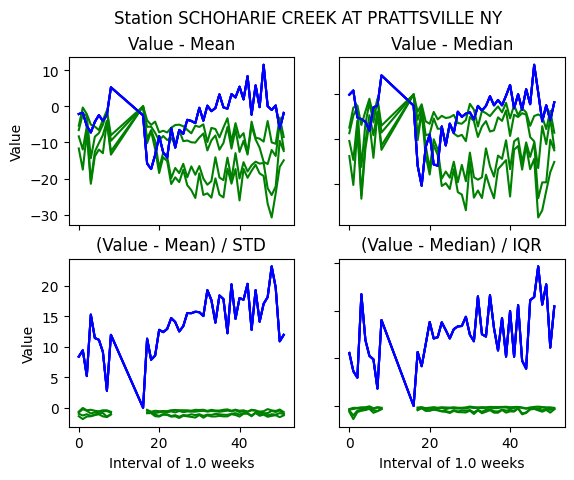

In [13]:
# Control Panel

# [114, 414, 410, 496, 60, 47, 476, 635, 484, 599, 55, 74, 644, 305, 376, 359, 280, 42, 278, 97, 657, 624, 623, 192, 136, 405, 397, 77, 619, 51, 497, 202, 525, 135, 440, 78, 99, 210, 590, 616, 177, 279, 667, 238, 1, 419, 626, 577, 386, 264, 266, 267, 185, 341, 371, 545, 356, 130, 648, 331, 536, 439, 350, 309, 39, 429, 271, 333, 14, 15, 610, 389, 390, 373, 622, 437, 438, 385, 22, 26, 637, 669, 272, 666, 11, 33, 28, 444, 25, 491, 493, 13, 16, 32, 360, 489, 518, 137, 579, 551, 654, 187, 12, 292, 67, 558, 299, 443, 409, 35, 487, 71, 10, 351, 312, 247, 552, 505, 614, 636, 607, 605, 34, 587, 483, 182, 284, 342, 561, 162, 490, 287, 596, 620, 101, 649, 514, 402, 455, 480, 150, 538, 277, 355, 76, 64, 470, 257, 417, 447, 383, 469, 662, 560, 629, 121, 41, 334, 68, 450, 392, 102, 479, 406, 571, 120, 562, 119, 5, 197, 152, 70, 124, 243, 265, 563, 363, 307, 573, 72, 582, 442, 19, 529, 404, 516, 73, 337, 138, 2, 3, 6, 52, 49, 255, 256, 344, 352, 20, 506, 606, 4, 377, 31, 485, 643, 196, 295, 30, 658, 583, 318, 195, 650, 511, 676, 94, 276, 375, 441, 145, 117, 345, 665, 21, 367, 190, 572, 65, 354, 18, 465, 300, 445, 680, 285, 395, 149, 274, 304, 655, 315, 329, 308, 659, 540, 365, 374, 100, 584, 388, 336, 594, 401, 24, 399, 40, 103, 403, 361, 368, 227, 231, 229, 234, 225, 220, 221, 651, 675, 521, 219, 222, 233, 498, 230, 347]
# 277
# ['SiteCode = 01350000', 'SiteCode = 03011020', 'SiteCode = 01531000', 'SiteCode = 04231600', 'SiteCode = 01325000', 'SiteCode = 01315500', 'SiteCode = 04223000', 'SiteCode = 04266500', 'SiteCode = 04227500', 'SiteCode = 04252500', 'SiteCode = 01321000', 'SiteCode = 01334500', 'SiteCode = 04269000', 'SiteCode = 01426500', 'SiteCode = 01512500', 'SiteCode = 01503000', 'SiteCode = 01421000', 'SiteCode = 01315000', 'SiteCode = 01420500', 'SiteCode = 01346000', 'SiteCode = 04273500', 'SiteCode = 04263000', 'SiteCode = 04262500', 'SiteCode = 01367500', 'SiteCode = 01357500', 'SiteCode = 01529500', 'SiteCode = 01526500', 'SiteCode = 01335754', 'SiteCode = 04260500', 'SiteCode = 01318500', 'SiteCode = 04232000', 'SiteCode = 01371500', 'SiteCode = 04234000', 'SiteCode = 01357499', 'SiteCode = 04216000', 'SiteCode = 01336000', 'SiteCode = 01347000', 'SiteCode = 01372500', 'SiteCode = 04249000', 'SiteCode = 04258000', 'SiteCode = 01362500', 'SiteCode = 01420980', 'SiteCode = 04275500', 'SiteCode = 01375000', 'SiteCode = 01200000', 'SiteCode = 03014500', 'SiteCode = 04264331', 'SiteCode = 04242500', 'SiteCode = 01521500', 'SiteCode = 01413500', 'SiteCode = 01414500', 'SiteCode = 01415000', 'SiteCode = 01365000', 'SiteCode = 01437500', 'SiteCode = 01509000', 'SiteCode = 04235500', 'SiteCode = 01502500', 'SiteCode = 01351500', 'SiteCode = 04270000', 'SiteCode = 01435000', 'SiteCode = 04235000', 'SiteCode = 04215500', 'SiteCode = 01500000', 'SiteCode = 01428500', 'SiteCode = 01312000', 'SiteCode = 04213500', 'SiteCode = 01417000', 'SiteCode = 01436000', 'SiteCode = 01304500', 'SiteCode = 01305000', 'SiteCode = 04256000', 'SiteCode = 01523500', 'SiteCode = 01524500', 'SiteCode = 01510000', 'SiteCode = 04262000', 'SiteCode = 04214500', 'SiteCode = 04215000', 'SiteCode = 01520500', 'SiteCode = 01306500', 'SiteCode = 01308500', 'SiteCode = 04268000', 'SiteCode = 04276500', 'SiteCode = 01417500', 'SiteCode = 04275000', 'SiteCode = 01303000', 'SiteCode = 01310500', 'SiteCode = 01309500', 'SiteCode = 04217000', 'SiteCode = 01308000', 'SiteCode = 04230500', 'SiteCode = 04231000', 'SiteCode = 01304000', 'SiteCode = 01305500', 'SiteCode = 01310000', 'SiteCode = 01505000', 'SiteCode = 04229500', 'SiteCode = 04233000', 'SiteCode = 01358000', 'SiteCode = 04243500', 'SiteCode = 04237496', 'SiteCode = 04271500', 'SiteCode = 01365500', 'SiteCode = 01303500', 'SiteCode = 01423000', 'SiteCode = 01329490', 'SiteCode = 04239000', 'SiteCode = 01425000', 'SiteCode = 04216500', 'SiteCode = 01530500', 'SiteCode = 01311500', 'SiteCode = 04228500', 'SiteCode = 01330500', 'SiteCode = 01302500', 'SiteCode = 01500500', 'SiteCode = 01433500', 'SiteCode = 01376800', 'SiteCode = 04237500', 'SiteCode = 04232050', 'SiteCode = 04257000', 'SiteCode = 04267500', 'SiteCode = 04254500', 'SiteCode = 04253500', 'SiteCode = 01311000', 'SiteCode = 04246500', 'SiteCode = 04227000', 'SiteCode = 01364500', 'SiteCode = 01421900', 'SiteCode = 01496500', 'SiteCode = 04240100', 'SiteCode = 01362200', 'SiteCode = 04230380', 'SiteCode = 01422500', 'SiteCode = 04250750', 'SiteCode = 04261000', 'SiteCode = 01348000', 'SiteCode = 04270200', 'SiteCode = 04232482', 'SiteCode = 01528000', 'SiteCode = 04219000', 'SiteCode = 04225000', 'SiteCode = 01361000', 'SiteCode = 04235250', 'SiteCode = 01420000', 'SiteCode = 01502000', 'SiteCode = 01335500', 'SiteCode = 01327750', 'SiteCode = 04221500', 'SiteCode = 01387450', 'SiteCode = 03013000', 'SiteCode = 04218000', 'SiteCode = 01514000', 'SiteCode = 04221000', 'SiteCode = 04274000', 'SiteCode = 04240010', 'SiteCode = 04265000', 'SiteCode = 01350180', 'SiteCode = 01314000', 'SiteCode = 01436500', 'SiteCode = 01329500', 'SiteCode = 04218518', 'SiteCode = 01525500', 'SiteCode = 01349000', 'SiteCode = 04224775', 'SiteCode = 01529950', 'SiteCode = 04240180', 'SiteCode = 01350140', 'SiteCode = 04240105', 'SiteCode = 01350120', 'SiteCode = 01301500', 'SiteCode = 01370000', 'SiteCode = 01361500', 'SiteCode = 01330000', 'SiteCode = 01350355', 'SiteCode = 01376500', 'SiteCode = 01414000', 'SiteCode = 04240120', 'SiteCode = 01507000', 'SiteCode = 01427500', 'SiteCode = 04240300', 'SiteCode = 01331095', 'SiteCode = 04245000', 'SiteCode = 04216418', 'SiteCode = 01306460', 'SiteCode = 04234061', 'SiteCode = 01529000', 'SiteCode = 04232650', 'SiteCode = 01333500', 'SiteCode = 01437000', 'SiteCode = 01358500', 'SiteCode = 01300000', 'SiteCode = 01300500', 'SiteCode = 01302000', 'SiteCode = 01319000', 'SiteCode = 01317000', 'SiteCode = 01387400', 'SiteCode = 01387420', 'SiteCode = 01497500', 'SiteCode = 01501000', 'SiteCode = 01306495', 'SiteCode = 0423205010', 'SiteCode = 04254000', 'SiteCode = 01301000', 'SiteCode = 01513500', 'SiteCode = 01309990', 'SiteCode = 04227995', 'SiteCode = 04268800', 'SiteCode = 01369500', 'SiteCode = 0142400103', 'SiteCode = 01309950', 'SiteCode = 04273700', 'SiteCode = 04245200', 'SiteCode = 01434025', 'SiteCode = 01369000', 'SiteCode = 04270500', 'SiteCode = 04232100', 'SiteCode = 04279000', 'SiteCode = 01344000', 'SiteCode = 01419500', 'SiteCode = 01511500', 'SiteCode = 04216200', 'SiteCode = 01359750', 'SiteCode = 01350080', 'SiteCode = 01498500', 'SiteCode = 04274500', 'SiteCode = 01306499', 'SiteCode = 01508000', 'SiteCode = 01366500', 'SiteCode = 04240200', 'SiteCode = 01328000', 'SiteCode = 01501500', 'SiteCode = 01306440', 'SiteCode = 0422026250', 'SiteCode = 01425500', 'SiteCode = 04217500', 'SiteCode = 04280450', 'SiteCode = 01422000', 'SiteCode = 01526000', 'SiteCode = 01360640', 'SiteCode = 01418500', 'SiteCode = 01426000', 'SiteCode = 04271815', 'SiteCode = 01434017', 'SiteCode = 01434498', 'SiteCode = 01428000', 'SiteCode = 04273800', 'SiteCode = 04235271', 'SiteCode = 01507500', 'SiteCode = 01510500', 'SiteCode = 01347500', 'SiteCode = 04245236', 'SiteCode = 01522500', 'SiteCode = 01436690', 'SiteCode = 04250200', 'SiteCode = 01527500', 'SiteCode = 01307500', 'SiteCode = 01527000', 'SiteCode = 01313500', 'SiteCode = 01349150', 'SiteCode = 01528700', 'SiteCode = 01505500', 'SiteCode = 01508500', 'SiteCode = 01374701', 'SiteCode = 01374901', 'SiteCode = 01374821', 'SiteCode = 01374941', 'SiteCode = 0137462010', 'SiteCode = 01374505', 'SiteCode = 01374531', 'SiteCode = 04270510', 'SiteCode = 04278300', 'SiteCode = 04233300', 'SiteCode = 0137449480', 'SiteCode = 01374559', 'SiteCode = 01374930', 'SiteCode = 04232034', 'SiteCode = 01374890', 'SiteCode = 01499000']
import statistics as stats
state = "NY"

# Year analysis begins
start_date = "1900"

# Year analysis ends
end_date = "2023"

# Specific date start ("01-05" for Jan 1 - Dec 31)
date = "01-05"

# Distance in weeks looked in each direction of date 
window_in_wks = 0.5
# determines which percentile is graphed, can be list of multiple percentiles
percentile = [5]

#data = get_usgs_sf(state, start_date, end_date)

# IF GETTING DATA FROM CODE, SET SITE TO 0
data = get_usgs_sf_code("01350000", start_date, end_date)

#for i in range(num_of_reps(data,0)):
    #print(f"{get_gw_date(data,0,i)}: {get_gw_value(data,0,i)}")
#print(data["value"]["timeSeries"][0])
#graph_comparison(show_site_data(data, 0, False), "10-20", start_date, end_date, 0, window_in_wks, True, percentile)
#percent(data, "01-05", start_date, end_date, percentile, state, "all")
percentile = [5,10,25,33]
#a = percent(data, "01-05", start_date, end_date, percentile, state, "0")
#using_all_weeks(data, date, start_date, end_date, 0, 2)
differences(data, "01-14", start_date, end_date, 0, window_in_wks)
# ^ STATS IS NONETYPE FIX THIS BROKEN




#get_station_info(data, state, start_date, end_date)

If I were to organize this beautifully, how would i do that?

Get station information
    Enter start year for collection:
    End year auto set to 2022 or 2023

    OUTPUT DATA

Get single station data
    Enter station code:
    Enter start year for collection:
    End year auto set to 2022 or 2023

    Range to look at:
    Monthly
    Week range (0.5-2) (1 to 4 weeks)
    Use all weeks

    Enter start date for analysis (one week range ahead of first lookat date)

    Statistics to apply:
    Graph percentile of data:
    Apply differences modification

    OUTPUT GRAPH AND DATA


In [9]:
# IMPORT DATA
station_code = []
start_year = []
end_year = 2023

# RANGE TO ANALYZE
monthly = False
week_range = [1]
use_all_weeks = False
start_date = "01-05"

# STATISTICS TO APPLY
graph_percentile = []
apply_differences = []


